In [ ]:
from google.colab import drive
drive.mount('/drive')

In [2]:
General steps:
    1) remove 20% at the edges of the cubes (ca. 2mm per 100mm edge length) (matlab script)
    2) crop image with sliding window to 900x600 slices (python script)
    3) pre-processing: GaussianBlur-Thresholding-Erode-Dilate-Close (this script)
    4) feature calculation (this script)
    5) clustering (e.g. PCA, k means) (python script)
       identify labels
    6) plot process-speed (python script)
    7) decide on pore features (python script)

SyntaxError: invalid syntax (<ipython-input-2-879e4ab189d7>, line 1)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely import geometry

# Image Preprocessing
Raw LOM images are processed via binarization, thresholding, blurring, eroding, and dialation to ignore scratches, uneven lighting, and stains from metallography. After this step, the images must be rotated and cropped manually so that the build direction is from bottom to up and only the approximate area, where pyrometer measurement was done would be included.

In [2]:
#change this if necessary: ret3,th_gaussian_blur = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

def showImage(displayImageOriginal):
    '''Basically displays the provided image.'''
    plt.figure(num=None, figsize=(800, 500), dpi=96, facecolor='w', edgecolor='k')
    plt.subplot(1, 1, 1), plt.imshow(displayImageOriginal, 'gray')
    plt.show()

    
def processImage(img_cv, histogramEqualization='NONE', GaussianBlur=True, GaussianBlurKernelSize=(1,1), 
                 erodeIterations=4, dilateIterations=2):
    ''''''
    import cv2
    import numpy as np
    from matplotlib import pyplot as plt
    import matplotlib.image as mpimg
    
    ### HIST QUALIZATION
    ## A good image will have pixels from all regions of the image, not only in some specific range of values.
    ## To do this, histogram equalization is applied.
    if histogramEqualization == 'NONE':
        #print('No histogram equalization applied.')
        equ_img = img_cv.copy()
    if histogramEqualization == 'EQUALIZE':
      ## Take grayscale image as an input and equalizes histogram.
        #print('cv2.equalizeHist function applied.')
        equ_img = cv2.equalizeHist(img_cv.copy())
    if histogramEqualization == 'CLAHE':
      ## When global equalization is not a good solution, adaptive histogram equalization is used.
      ## An image is divided into small blocks, called "tiles" and each are histogram equalized.
        #print('CLAHE  applied.')
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        equ_img = clahe.apply(img_cv.copy())

    ###### GAUSSIAN BLUR AND THRESHOLDING
    # Otsu's thresholding after Gaussian filtering
    if GaussianBlur:
        blur = cv2.GaussianBlur(equ_img, GaussianBlurKernelSize, 0)

#         ret3,th_gaussian_blur = 255-cv2.threshold(blur,140,255,cv2.THRESH_BINARY)
#         ret3,th_gaussian_blur = cv2.threshold(th_gaussian_blur,140,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        th_gaussian_blur = cv2.adaptiveThreshold(blur,255, 
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv2.THRESH_BINARY, 
                              31, 
                              15)
    else:
        th_gaussian_blur = equ_img
    
    ###### ERODE + DILATE
    kernel = np.ones((1,1), np.uint8)
    if erodeIterations>0:
        gaus_erode = cv2.erode(th_gaussian_blur, kernel, iterations=erodeIterations)
    else: 
        gaus_erode = th_gaussian_blur
    
    if dilateIterations>0:
        gaus_erode_dilate = cv2.dilate(gaus_erode, kernel, iterations=dilateIterations)
        gaus_erode_dilate = cv2.morphologyEx(gaus_erode_dilate, cv2.MORPH_CLOSE, kernel)
    else: 
        gaus_erode_dilate=gaus_erode
        
    return gaus_erode_dilate


## Test

(-0.5, 599.5, 599.5, -0.5)

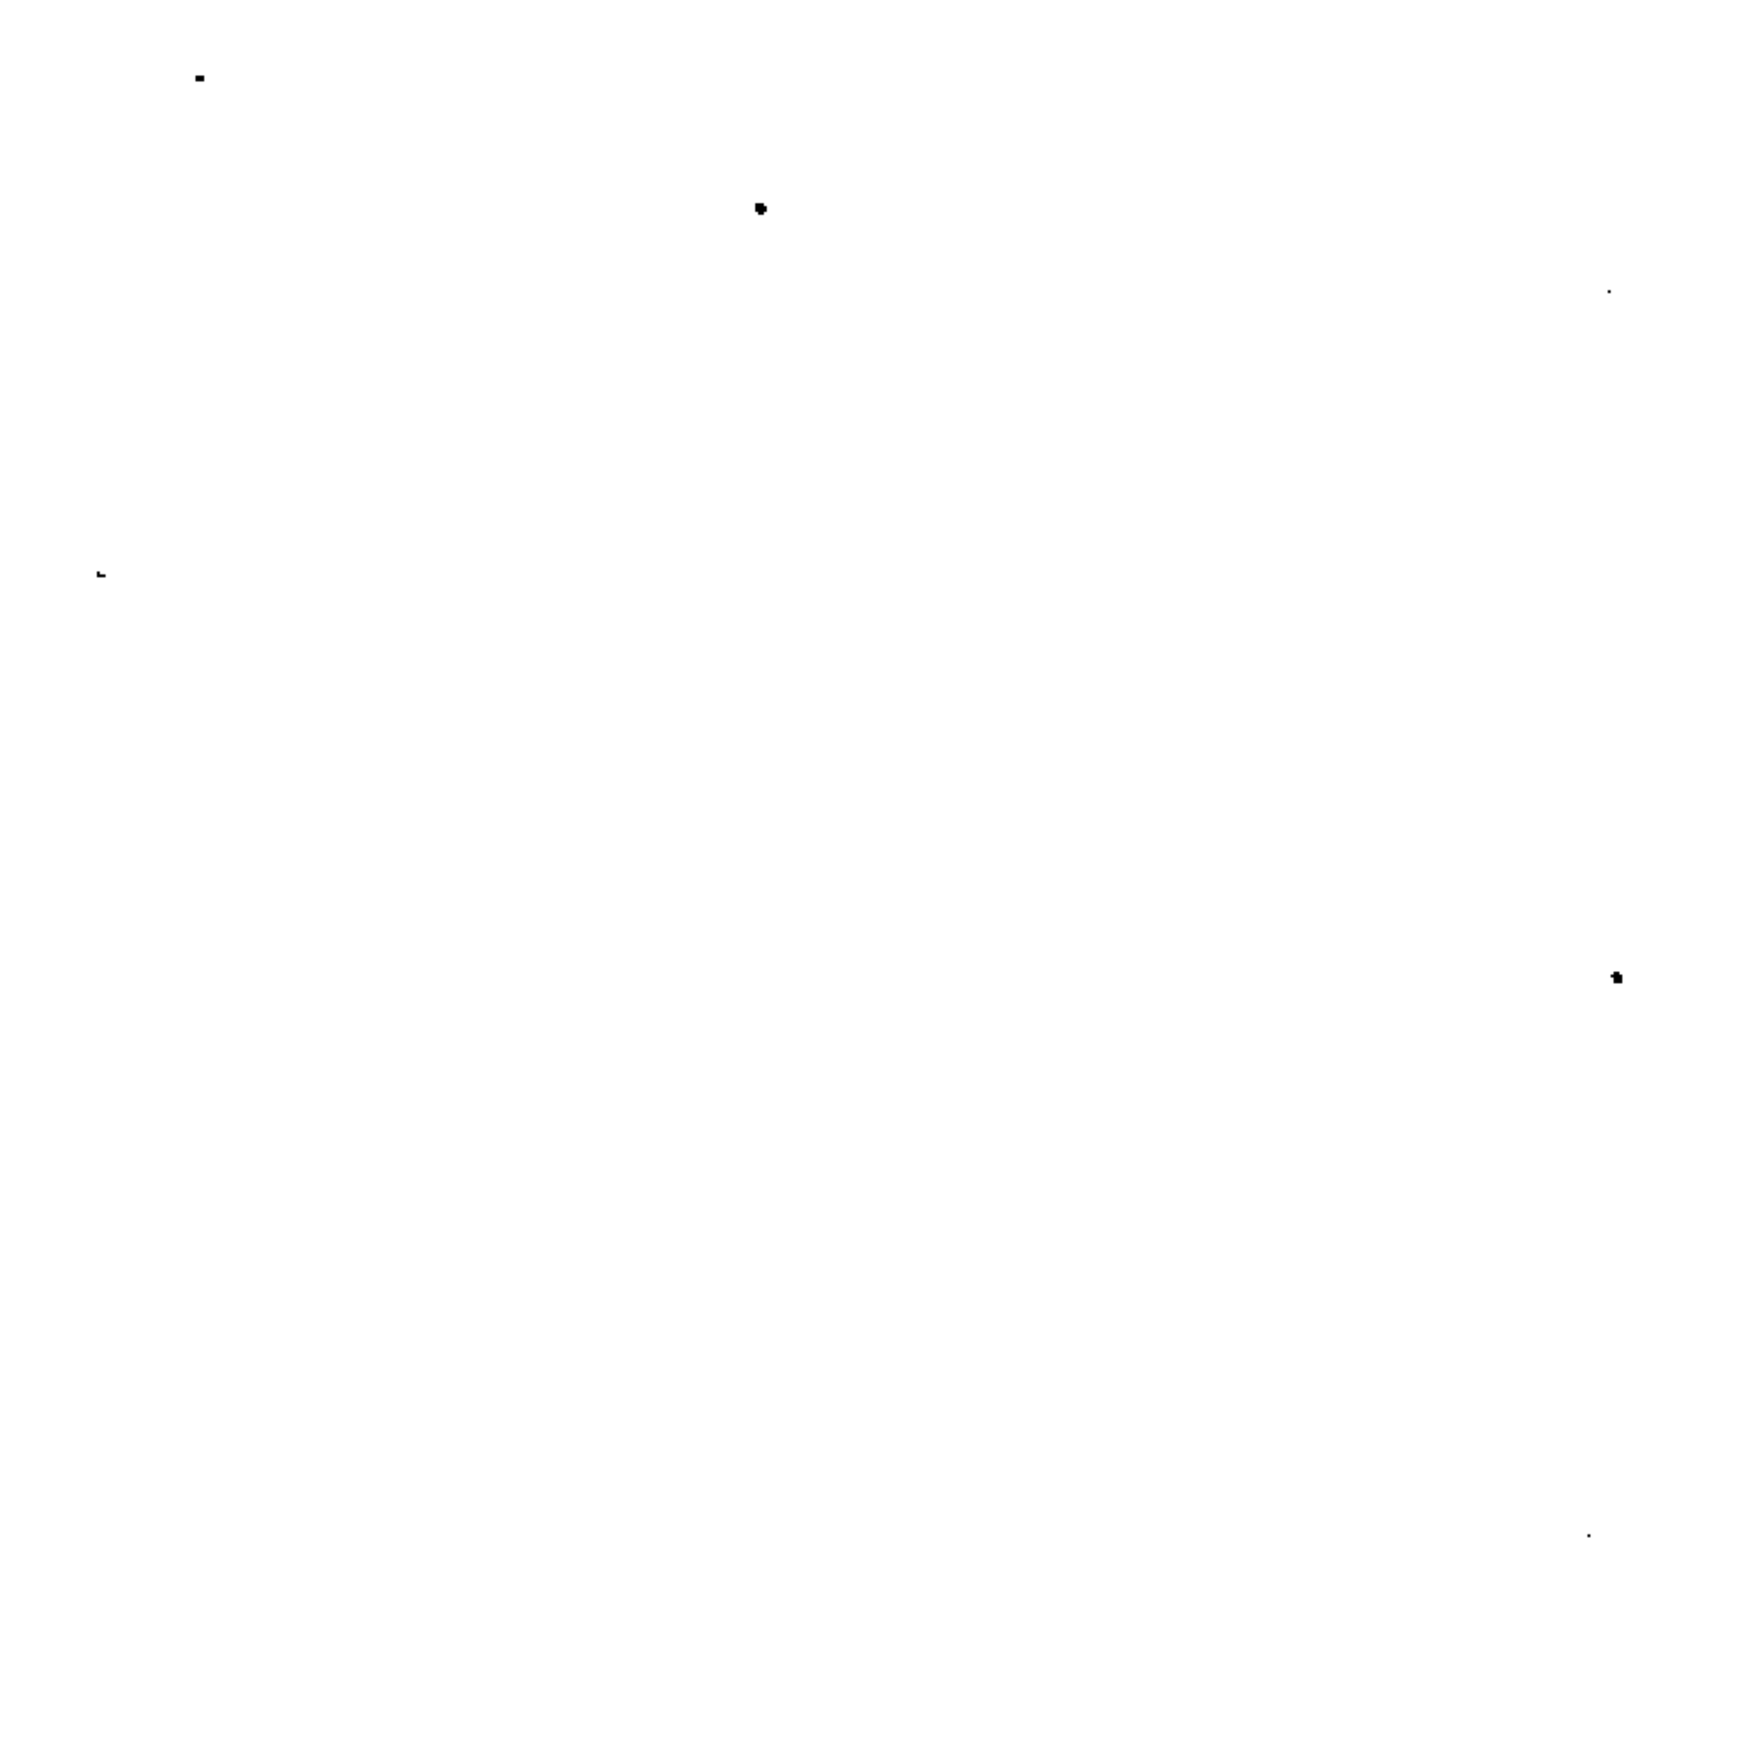

In [15]:
#Before running processImage() and imagePreprocess() find first suitable parameters

img_path = r"F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\testset_600100W_650mms_3_1.tif"
img_cv = cv2.imread(img_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
#equ_img = (255-img_cv.copy())
equ_img = (img_cv.copy())

###### GAUSSIAN BLUR AND THRESHOLDING
# Otsu's thresholding after Gaussian filtering

blur = cv2.GaussianBlur(equ_img, (7, 7), 0)
plt.figure(figsize = (32, 32))
plt.imshow(equ_img, cmap = 'gray')

plt.axis('off')
#plt.savefig(r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed\after_Gaussian_blur.jpg")


(-0.5, 599.5, 599.5, -0.5)

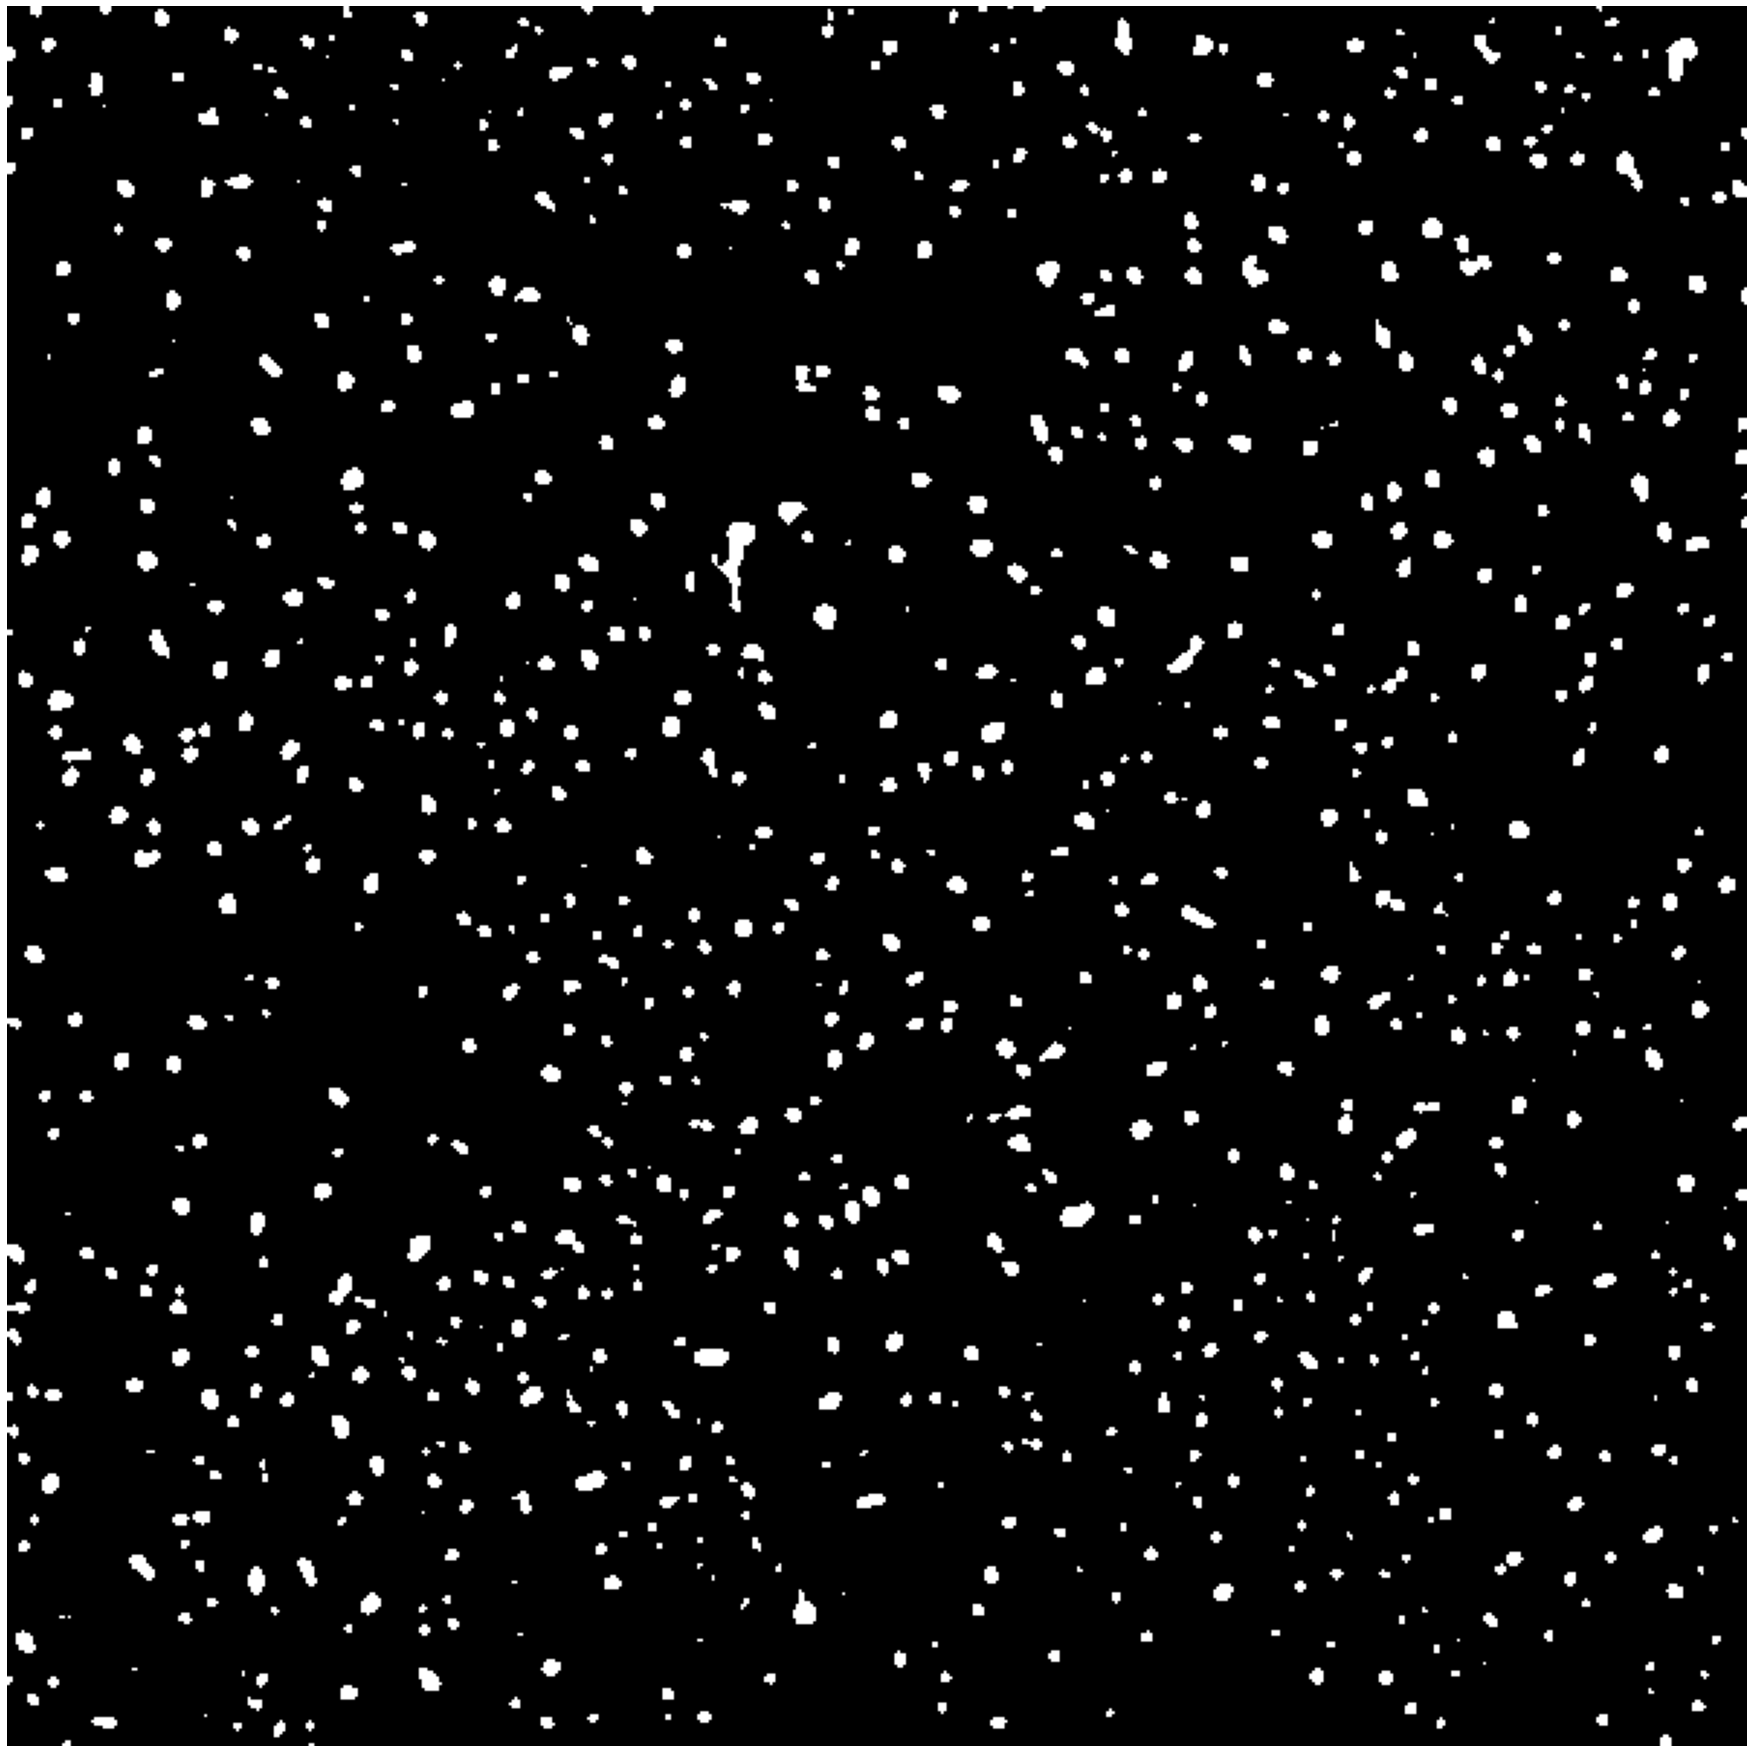

In [32]:

#ret3,th_gaussian_blur = cv2.threshold(blur,140,255,cv2.THRESH_BINARY)
#th_gaussian_blur_inv = th_gaussian_blur 
#ret3,th_gaussian_blur = cv2.adaptivethreshold(blur,40,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
th_gaussian_blur = 255-cv2.adaptiveThreshold(blur,255, 
                              cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                              cv2.THRESH_BINARY, 
                              31, 
                              15)

#th_gaussian_blur = cv2.adaptiveThreshold(blur,255, 
#                              cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,31,10)
plt.figure(figsize = (32, 32))
plt.imshow(th_gaussian_blur, cmap = 'gray')
plt.axis('off')
#plt.savefig(r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed\after_otsu_thresholding.jpg")

In [ ]:
histogram, bin_edges = np.histogram(img_cv, bins=256, range=(0, 1))

In [ ]:
plt.subplot(1,2,1)
plt.imshow(blur,cmap='gray')
plt.title('image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
hist,bin = np.histogram(blur.ravel(),256,[0,255])
plt.xlim([0,255])
plt.plot(hist)
plt.title('histogram')

plt.show()

In [ ]:

#ret3,th_gaussian_blur = cv2.threshold(blur,140,255,cv2.THRESH_BINARY)
#th_gaussian_blur_inv = th_gaussian_blur 
ret3,th_gaussian_blur = cv2.threshold(blur,40,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.figure(figsize = (32, 32))
plt.imshow(th_gaussian_blur, cmap = 'gray')
plt.axis('off')
#plt.savefig(r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed\after_otsu_thresholding.jpg")

In [ ]:
kernel = np.ones((1,1), np.uint8)

gaus_erode = cv2.erode(th_gaussian_blur, kernel, iterations=4)
plt.figure(figsize = (32, 32))
plt.imshow(gaus_erode, cmap = 'gray')
plt.axis('off')
#plt.savefig(r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed\after_eroding.jpg")

In [ ]:
kernel = np.ones((1,1), np.uint8)
gaus_erode_dilate = cv2.dilate(gaus_erode, kernel, iterations=2)
plt.figure(figsize = (32, 32))
plt.imshow(gaus_erode_dilate,  cmap = 'gray')
plt.axis('off')
#plt.savefig(r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed\after_dilating.jpg")

In [ ]:
closing = cv2.morphologyEx(gaus_erode_dilate, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize = (32, 32))
plt.imshow(closing,  cmap = 'gray')
plt.axis('off')

In [ ]:
def crop_images(img_path):
  image = cv2.imread(img_path)
  height, width, channels = image.shape
  y=45
  x=120
  crop_factor = 0.2
  h=height-100
  w=width-120
  crop = image[y:y+h, x:x+w]
  
  return crop

In [ ]:
for images in os.listdir(folder_path):
  image_path = os.path.join(folder_path, images)
  image_name = images.split('.')[0]
  new_path = folder_path + '/' + image_name + '_cropped.jpg'
  image = cv2.imread(image_path)
  height, width, channels = image.shape  
  y=50
  x=120
  h=height-150
  w=width-120
  crop = image[y:h, x:w]
  cv2.imwrite(new_path, crop)

In [ ]:
for images in os.listdir(folder_path):
  image_path = os.path.join(folder_path, images)
  image_name = images.split('.')[0]
  new_path = folder_path + '/' + image_name + '_01.jpg'
  image = cv2.imread(image_path)
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale

  contours, hierarchy = cv2.findContours(grayImage,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE) # detect contours 

  #contours = contours[0] if len(contours) == 2 else contours[1]

  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    print(x,y,w,h)
    crop = grayImage[y:y+h, x:x+w]
    print(crop)
    break
  cv2.imwrite(new_path, crop)
  

In [10]:
!mkdir processedImages

Ein Unterverzeichnis oder eine Datei mit dem Namen "img_folder_path2+\img\processedImages" existiert bereits.


In [11]:
ls

 Datentr„ger in Laufwerk F: ist TOSHIBA EXT
 Volumeseriennummer: 3EB7-16B4

 Verzeichnis von F:\ETH Sicherung\ETH\Yujung Drive

25.05.2023  18:51    <DIR>          .
25.05.2023  18:51    <DIR>          ..
10.05.2023  18:52    <DIR>          .idea
22.03.2023  17:03    <DIR>          .ipynb_checkpoints
12.01.2023  09:50         1.122.276 2point_update_yao.ipynb
06.01.2023  15:43         1.226.521 ActiveLearning_toShare.ipynb
22.02.2023  16:08             1.280 cut.py
09.08.2023  11:11    <DIR>          img_folder_path2+
09.01.2023  16:54           108.329 Less complex CNN.ipynb
06.01.2023  16:02    <DIR>          LOM Images
06.01.2023  15:43         4.153.108 LOM Images-20230106T134311Z-001.zip
09.08.2023  11:11         1.822.833 LOM_Image_Feature_Extraction.ipynb
16.01.2023  12:24    <DIR>          LOM_Images
23.05.2023  14:57    <DIR>          LOM_Images-20230106T134315Z-001
06.01.2023  15:44       270.117.512 LOM_Images-20230106T134315Z-001.zip
07.11.2022  12:56         6.213.989 Mast

In [ ]:
folder_path = r"C:\Users\mackerm\Desktop\ETH\Aconity MIDI\processedImages"

In [34]:
#create a new folder for images "to_binarize" and copy image folder into it, 
#then add empty folder "processedImages into" image folder

img_folder_path2 = r"F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize"
image_preprocess(img_folder_path2)


F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_3_7.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600100W_650mms_1_1.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600100W_650mms_1_2.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600100W_650mms_1_4.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600100W_650mms_1_5.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600100W_650mms_1_6.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\te

F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_2_4.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_2_5.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_2_6.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_2_7.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_3_1.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\testset_600120W_750mms_3_2.tif
F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\testset_600\to_binarize\img\processedImages\te

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [9]:
def image_preprocess(directory):
  # Directory includes folders, which contains images
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
        
    for image in os.listdir(folder_path):
      image_path = os.path.join(folder_path, image)
      #image_name = image.split(".")[0]
      img = cv2.imread(image_path)
      gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #gray_img_inv = (255 - gray_img)

      processed_img = processImage(gray_img, histogramEqualization='NONE', 
                                    GaussianBlur=True, GaussianBlurKernelSize=(7,7), 
                                    erodeIterations=1, dilateIterations=1)
        

      #new_path = os.path.join(folder_path, "processedImages", image_name) + '_processed'+'.tif'
      new_path = os.path.join(folder_path, "processedImages", image)
      print(new_path)
      
      cv2.imwrite(new_path, processed_img)

In [ ]:
from PIL import ImageOps
import os

# Define the input and output folders
input_folder = r'F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\unused samples\results\1_crop\to_binarize\img\processedImages'
output_folder = r'C:/Users/mackerm/Desktop/ETH/Aconity MIDI/inverted/'

# Loop through all the files in the input folder
for file_name in os.listdir(input_folder):
    # Check if the file is an image
    if file_name.endswith('.tif') or file_name.endswith('.png'):
        # Open the image
        image = Image.open(input_folder + file_name)

        # Invert the image
        inverted_image = ImageOps.invert(image)

        # Save the inverted image in the output folder with the same file name
        inverted_image.save(output_folder + file_name)


# Object Detection
Detect polygons, lines, and points of the preprocess images following the functions above using contour detection of CV2. The coordinates of contours are used for further calculation of features.

In [15]:
def polygon_detection(img_path):
  from shapely import geometry

  image = cv2.imread(img_path)
  imageCopy=np.copy(image)
  grayImage=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert image to grayscale

  contours, hierarchy = cv2.findContours(grayImage,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE) # detect contours
  print(len(contours), "contours detected.")
  #cv2.drawContours(imageCopy,contours,0,(0,255,255),2) # to draw a specific contour or all contours

  # filter by size
  for i, c in enumerate(contours):
      areaContour=cv2.contourArea(c)
      #if areaContour<5000 or 500000<areaContour: 
      #    continue
      cv2.drawContours(imageCopy,contours,i,(255,10,255),1)

  list_of_polygons = []
  list_of_points = [] 
  list_of_lines = []

  for x in contours:
    if len(x) > 3:
      poly = geometry.Polygon([[p[0][0], p[0][1]] for p in x])
      list_of_polygons.append(poly)
    if len(x) == 2:
      line = geometry.LineString([[p[0][0], p[0][1]] for p in x])
      list_of_lines.append(line)  
    if len(x) == 1:
      #print(x)
      point = geometry.Point([x[0][0][0], x[0][0][1]])
      list_of_points.append(point)
      
  print('Number of polygons: ', len(list_of_polygons))
  print('Polygon detection finished.')
  return list_of_polygons, list_of_lines, list_of_points

In [4]:
def equivalentDiameter(poly):
    equivalentRadius = math.sqrt(poly.area / math.pi)
    equivalentDiameter = 2 * equivalentRadius
    return equivalentDiameter

In [5]:
# More preprocessing of detected objects. If the distance of two object is smaller
# than the smaller object, they are considered as one due to the fracture mechenism.
# And the points with distance of one is also converted into polygons for the same
# reason. Points and polygons are deleted or added accordingly.

def poly_preprocessing(img_path): 
  import shapely
  from shapely.ops import nearest_points
  
  list_of_polygons, list_of_lines, list_of_points = polygon_detection(img_path)
  list_of_polygons.pop(0) # Because the first polygon is the boundary of the entire image
  print('Preprocessing of obtained polygons starting...')
  # Calculate distances from one iterrated polygon to the other ones in the list
  for i in range(0, len(list_of_polygons)):
    if i < len(list_of_polygons):
      target = list_of_polygons[i]
      nrst_points = [] 

      for j in range(0, len(list_of_polygons)):
        if i != j: # To exclude the polygon, distances of which to the other polygons are calculated
          # Find the nearest point of the compared, not POLYGON!
          nrst_point = list(nearest_points(target, list_of_polygons[j])) 
          # Calculate the distance
          nrst_distance = nrst_point[0].distance(nrst_point[1]) 

          new_row =[nrst_point[1], nrst_distance]
          nrst_points.append(new_row)

      nrst_points = pd.DataFrame(nrst_points, columns = ["points", "distance"])
      # The minimum distance this polygon is to the others
      distance = nrst_points.min(axis = 1)[1]
      # Save the polygon with the closet point as another variable
      poly = list_of_polygons[nrst_points["distance"].idxmin()]
    
    # Check if the distance is smaller than either of the polygons 
    # If so, merge the two polygons and remove the one compared to (not target polygon)
      if distance > 0 and (distance < equivalentDiameter(poly) or distance < equivalentDiameter(target)):
        polygons = [target, poly]
        merged_polygons = shapely.ops.unary_union(polygons)
        list_of_polygons[i] = merged_polygons
        if isinstance(poly, type(list_of_polygons)):
          list_of_polygons.remove(poly)

  print('Preprocessing of polygon data finished.')
  return list_of_polygons

# Feature Calculation
Detected objects above are used to calculate features below. The functions are from Marc and his colleagues.

In [5]:
import math
from shapely.geometry import Point, Polygon, LineString

In [49]:
# ## expects a shapely polygon as input
# def aspectRatio(poly):
#   # get minimum bounding box around polygon
#   box = poly.minimum_rotated_rectangle
#   # get coordinates of polygon vertices
#   x, y = box.exterior.coords.xy
#   # get length of bounding box edges
#   edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
#   # get length of polygon as the longest edge of the bounding box
#   length = max(edge_length)
#   # get width of polygon as the shortest edge of the bounding box
#   width = min(edge_length)
#   aspectRatio = length / width

#   return aspectRatio

In [81]:

from shapely.geometry import Point

def aspectRatio(poly):
    # Get minimum bounding box around polygon
    box = poly.minimum_rotated_rectangle
    # Get coordinates of polygon vertices
    x, y = box.exterior.coords.xy
    # Get length of bounding box edges
    edge_length = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    # Get length of polygon as the longest edge of the bounding box
    length = max(edge_length)
    # Get width of polygon as the shortest edge of the bounding box
    width = min(edge_length)
    aspect_ratio = length / width

    # Calculate the centroid of the polygon
    centroid = poly.centroid

    # Get the x and y coordinates of the centroid
    centroid_x, centroid_y = centroid.x, centroid.y

    return aspect_ratio, centroid_x, centroid_y


In [7]:
def shapeFactor(pol):
    area = pol.area
    if area == 0:
      shapeFactor = 0
    else:
      perimeter = pol.length
      equivalentRadius = math.sqrt(area / math.pi)
      equivalentPerimeter = 2 * math.pi * equivalentRadius
      shapeFactor = perimeter / equivalentPerimeter
    return shapeFactor

In [8]:
def minorAndMajorAxisLength(poly):
  # get the minimum bounding rectangle and zip coordinates into a list of point-tuples
  mbr_points = list(zip(*poly.minimum_rotated_rectangle.exterior.coords.xy))
  # calculate the length of each side of the minimum bounding rectangle
  mbr_lengths = [LineString((mbr_points[i], mbr_points[i+1])).length for i in range(len(mbr_points) - 1)]
  # get major/minor axis measurements
  minor_axis = min(mbr_lengths)
  major_axis = max(mbr_lengths)
  return minor_axis, major_axis

In [9]:
def eccentricity (minor_axis_length, major_axis_length):
  return minor_axis_length / major_axis_length

In [10]:
def roundness(poly):
  area = poly.area
  convex_perimeter = poly.convex_hull.length
  roundness = (4* math.pi * area) / (convex_perimeter ** 2)
  return roundness

In [11]:
from rdfpy import rdf
def radial_correlation(dataframe, dr=0.1):
    x = dataframe['centroid_x'].values
    y = dataframe['centroid_y'].values
    # coords=dataframe['Centroid']

    # Combine x and y into a single NumPy array of coordinates.
    coords = np.column_stack((x, y))

    # Calculate the RDF.
    g_r, radii = rdf(coords, dr=dr)

    return g_r, radii

In [12]:
import numpy as np
import math
import collections
import matplotlib.pyplot as plt


def visualizeVectors(matrix):
    '''
    This method visualizes a vector. 
    
    INPUT: A Numpy Matrix. 
    
    '''
    vectors, dimensions = matrix.shape
    
    limits = 2*np.amax(abs(matrix), axis = 0)
    print(limits)
    colors = ['b','r','k']
    
    for i in range(vectors):
        plt.arrow(0,0,matrix[i,0],matrix[i,1],head_width=0.05,head_length=0.1,color = colors[i])
    
    plt.plot(0,0,'ok') #<-- plot a black point at the origin
    plt.axis('equal')  #<-- set the axes to the same scale
    plt.xlim([-limits[0],limits[0]]) #<-- set the x axis limits
    plt.ylim([-limits[1],limits[1]]) #<-- set the y axis limits
    plt.grid(b=True, which='major') #<-- plot grid lines
    plt.show()


def getAngleBetweenVectors(v1, v2):
    '''
    Calculates the angle between two vectors. 
    Input vectors must be provided as Numpy arrays. 
    
    INPUTS: v1 and v2: Numpy array.
    
    OUTPUT: angle between the two vectors. A value between 0 - 180. 
    
    '''
    o = np.array([0, 0])
    a = v1 - o
    b = v2 - o
    
    angle = 0
    
    if np.array_equal(a, b):
        angle = 0
        return(np.degrees(angle))
    else: 
        cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        #print("cosine angle: ", cosine_angle)
        angle = np.arccos(cosine_angle)
        #print("angle", angle)
        if math.isnan(angle):
            angle = 0
        return(np.degrees(angle))

    return(-1)


def uniqueness(poly, t=1, verbose=False):
    '''
    This method calculates the uniqueness metric of a closed polygon. 
    Uniqueness is the entropy of the histogram the angle differences between consequtive tangents of a polygon. 
    The histogram is calculated in two steps:
        1) Compute the tangent vector of each point of the contour,
        2) Compute the histogram of the angle difference between consecutive tangents.  
    
    Implemented using the formulas in Liu et al, 2016. 
    
    INPUTS: 
    poly: The contour, in the format of an OpenCV contour.
    t: The number of points to skip when comparing tangents. 
    
    OUTPUT: 
    uniqueness: A value between 0 and 1. 
        A small entropy indicates a skewed histogram, thus, polygon containing more of  a single kind of angle, either acute or obtuse.
        A large entropy means a uniform distribution on the histogram, thus, a more complicated shape that contains both acute and obtuse angles. 
    '''
    uniqueness = 0
    v_list = []
    dict_angle = {}
    poly_type = "cv_contour"
    global max_angle
    max_angle = 0
    #print(poly[-2][0][0])
    
    if str(type(poly)) == "<class 'shapely.geometry.polygon.Polygon'>":
        poly_type = "shapely"
        poly = list(poly.exterior.coords)
            
    
    ### STEP 1: Calculate the tangents for each point on the contour.
    for i in range(len(poly)): 
        if poly_type == "shapely":
            
            p1_x = poly[i-2][0]
            p1_y = poly[i-2][1]
            p2_x = poly[(i+2)%len(poly)][0]
            p2_y = poly[(i+2)%len(poly)][1]
            #print(p1_x, p1_y, p2_x, p2_y)
        else:
            p1_x = poly[i-2][0][0]
            p1_y = poly[i-2][0][1]
            p2_x = poly[(i+2)%len(poly)][0][0]
            p2_y = poly[(i+2)%len(poly)][0][1]
        #print(i, [p1_x, p1_y], [p2_x, p2_y])
        deltaY = p2_y - p1_y
        deltaX = p2_x - p1_x
        tangent = np.array([deltaX, deltaY])
        #print(i, tangent)
        v_list.append(tangent)
        
    ### STEP 2: Compare the angle differences between t-consecutive tangents.
    count = 0
    for i in range(0, len(v_list), t):
        #print(i, v_list[(i+1)%len(v_list)], v_list[i])
        angle = math.floor(getAngleBetweenVectors(v_list[(i+1)%len(v_list)], v_list[i]))
        if angle > max_angle:
            max_angle = angle
        count = count + 1
        #angle = getVectorAngle(v_list[((i+1)*t)%len(v_list)] - v_list[i]*t)
        if verbose:
            print(i, math.floor(angle))

        if angle in dict_angle.keys():
            #print(angle)
            dict_angle[angle] = dict_angle[angle] + 1 
        else:
            dict_angle[angle] = 1 
    if verbose: 
        print("Number of tangent angle difference calculations: ", count)
    for key in dict_angle.keys():
        hist_value = dict_angle[key] / count
        #print(hist_value*count)
        uniqueness += np.log10(hist_value) * hist_value
        #print(uniqueness)
    od = collections.OrderedDict(sorted(dict_angle.items()))

    for key in od.keys():
        od[key] = od[key] / count

    if verbose:
        print("Uniqueness: ", -uniqueness)
        print(od)
    return -uniqueness

# Save data in CSV file

In [52]:
import pandas as pd

#img_path = "/drive/MyDrive/Colab Notebooks/Masterarbeit/Datasets/Test_dataset/LOM_Images_byLabel_processed/Okay/Okay_BuildJob02_Sample23_processed_cropped.jpg"
#img_folder_path = "/drive/MyDrive/Colab Notebooks/Masterarbeit/Metadata/LOM Images/BuildJob2"
#img_folder_path = r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed"
img_folder_path = r"F:\ETH Sicherung\ETH\Yujung Drive\images\Bilder"
for img in os.listdir(img_folder_path):
  img_path = os.path.join(img_folder_path, img)
  if os.path.isdir(img_path):
    pass
  else:
    img_name = img.split('.')[0]
    print(img_name)
    final_df = pd.DataFrame(columns = ['Polygon', 
                                      'Area',
                                      'Aspect Ratio',
                                      'Shape Factor',
                                      'Minor Axis Length',
                                      'Major Axis Length',
                                      'Eccentricity',
                                      'Roundness'])

    # Detect polygons
    list_of_polygons, _, _ = polygon_detection(img_path)#poly_preprocessing(img_path)
    list_of_polygons.pop(0)
    # Calculate features based on the detected polygon coordinates
    for i in range(0, len(list_of_polygons)):
      poly = list_of_polygons[i]
      minor_axis_length, major_axis_length = minorAndMajorAxisLength(poly)

      final_df.loc[i, 'Polygon'] = poly
      final_df.loc[i, 'Area'] = poly.area
      final_df.loc[i, 'Aspect Ratio'] = aspectRatio(poly)
      final_df.loc[i, 'Shape Factor'] = shapeFactor(poly)
      final_df.loc[i, 'Minor Axis Length'] = minor_axis_length
      final_df.loc[i, 'Major Axis Length'] = major_axis_length
      final_df.loc[i, 'Eccentricity'] = eccentricity(minor_axis_length, major_axis_length)
      final_df.loc[i, 'Roundness'] = roundness(poly)

    new_path = img_folder_path + img_name + ".csv"
    final_df.to_csv(new_path)

ordered
20 contours detected.
Number of polygons:  20
Polygon detection finished.
cluster
21 contours detected.
Number of polygons:  21
Polygon detection finished.


In [90]:
import pandas as pd


#img_path = "/drive/MyDrive/Colab Notebooks/Masterarbeit/Datasets/Test_dataset/LOM_Images_byLabel_processed/Okay/Okay_BuildJob02_Sample23_processed_cropped.jpg"
#img_folder_path = "/drive/MyDrive/Colab Notebooks/Masterarbeit/Metadata/LOM Images/BuildJob2"
#img_folder_path = r"C:\Users\mackerm\Desktop\ETH\Yujung Drive\LOM_Images\processed"
img_folder_path = r"F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\600\to_binarize\img\processedImages_600x600"
for img in os.listdir(img_folder_path):
  img_path = os.path.join(img_folder_path, img)
  if os.path.isdir(img_path):
    pass
  else:
    img_name = img.split('.')[0]
    print(img_name)
    final_df = pd.DataFrame(columns = ['Polygon', 
                                      'Area',
                                      'Aspect Ratio',
                                      'Shape Factor',
                                      'Minor Axis Length',
                                      'Major Axis Length',
                                      'Eccentricity',
                                      'Roundness',
                                      'Uniqueness',
                                       'Max angle',
                                      'Pore counts',
                                       'Coordinates',
                                 'centroid_x','centroid_y ',
                                      ])

    # Detect polygons
    list_of_polygons, _, _ = polygon_detection(img_path)#poly_preprocessing(img_path)
    list_of_polygons.pop(0)
    # Calculate features based on the detected polygon coordinates
    for i in range(0, len(list_of_polygons)):
      aspect_ratio, centroid_x, centroid_y = aspectRatio(poly)
      poly = list_of_polygons[i]
      minor_axis_length, major_axis_length = minorAndMajorAxisLength(poly)

      final_df.loc[i, 'Polygon'] = poly
      final_df.loc[i, 'Area'] = poly.area
      final_df.loc[i, 'Aspect Ratio'] = aspect_ratio
      final_df.loc[i, 'Shape Factor'] = shapeFactor(poly)
      final_df.loc[i, 'Minor Axis Length'] = minor_axis_length
      final_df.loc[i, 'Major Axis Length'] = major_axis_length
      final_df.loc[i, 'Eccentricity'] = eccentricity(minor_axis_length, major_axis_length)
      final_df.loc[i, 'Roundness'] = roundness(poly)
      final_df.loc[i, 'Uniqueness'] = uniqueness(poly)
      final_df.loc[i, 'Max angle'] = max_angle
      final_df.loc[i, 'Pore counts'] = len(list_of_polygons)
      final_df.loc[i, 'centroid_x'] = centroid_x  # Save centroid X coordinate
      final_df.loc[i, 'centroid_y'] = centroid_y  # Save centroid Y coordinate
    new_path = img_folder_path + img_name + ".csv"
    final_df.to_csv(new_path, index = False)

4_1_1
33 contours detected.
Number of polygons:  33
Polygon detection finished.
4_1_2


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars


7 contours detected.
Number of polygons:  7
Polygon detection finished.
4_2_1
33 contours detected.
Number of polygons:  33
Polygon detection finished.
4_2_2
30 contours detected.
Number of polygons:  30
Polygon detection finished.
4_2_3
19 contours detected.
Number of polygons:  19
Polygon detection finished.
4_3_1
29 contours detected.
Number of polygons:  29
Polygon detection finished.
4_3_2
15 contours detected.
Number of polygons:  15
Polygon detection finished.
4_3_3
11 contours detected.
Number of polygons:  11
Polygon detection finished.
4_3_4
12 contours detected.
Number of polygons:  12
Polygon detection finished.
4_4_1
36 contours detected.
Number of polygons:  36
Polygon detection finished.
4_4_2
15 contours detected.
Number of polygons:  15
Polygon detection finished.
4_4_3
13 contours detected.
Number of polygons:  13
Polygon detection finished.
4_4_4
19 contours detected.
Number of polygons:  19
Polygon detection finished.
5_1_1
9 contours detected.
Number of polygons:  

C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in arccos


36 contours detected.
Number of polygons:  36
Polygon detection finished.
6_4_4
22 contours detected.
Number of polygons:  22
Polygon detection finished.
7_1_1
29 contours detected.
Number of polygons:  29
Polygon detection finished.
7_1_2
53 contours detected.
Number of polygons:  53
Polygon detection finished.
7_1_3
18 contours detected.
Number of polygons:  18
Polygon detection finished.
7_1_4
19 contours detected.
Number of polygons:  19
Polygon detection finished.
7_2_1
22 contours detected.
Number of polygons:  22
Polygon detection finished.
7_2_2
23 contours detected.
Number of polygons:  23
Polygon detection finished.
7_2_3
34 contours detected.
Number of polygons:  34
Polygon detection finished.
7_2_4
41 contours detected.
Number of polygons:  41
Polygon detection finished.
7_3_1
16 contours detected.
Number of polygons:  16
Polygon detection finished.
7_3_2
24 contours detected.
Number of polygons:  24
Polygon detection finished.
7_3_3
44 contours detected.
Number of polygons

15_3_1
53 contours detected.
Number of polygons:  53
Polygon detection finished.
15_3_2
30 contours detected.
Number of polygons:  30
Polygon detection finished.
15_3_3
34 contours detected.
Number of polygons:  34
Polygon detection finished.
15_3_4
22 contours detected.
Number of polygons:  22
Polygon detection finished.
15_4_1
4 contours detected.
Number of polygons:  4
Polygon detection finished.
15_4_2
23 contours detected.
Number of polygons:  23
Polygon detection finished.
15_4_3
13 contours detected.
Number of polygons:  13
Polygon detection finished.
15_4_4
7 contours detected.
Number of polygons:  7
Polygon detection finished.
16_1_1
22 contours detected.
Number of polygons:  22
Polygon detection finished.
16_1_2
30 contours detected.
Number of polygons:  30
Polygon detection finished.
16_1_3
34 contours detected.
Number of polygons:  34
Polygon detection finished.
16_1_4
16 contours detected.
Number of polygons:  16
Polygon detection finished.
16_2_1
34 contours detected.
Num

22_1_1
107 contours detected.
Number of polygons:  107
Polygon detection finished.
22_1_2
108 contours detected.
Number of polygons:  108
Polygon detection finished.
22_1_3
95 contours detected.
Number of polygons:  95
Polygon detection finished.
22_1_4
88 contours detected.
Number of polygons:  88
Polygon detection finished.
22_2_1
107 contours detected.
Number of polygons:  107
Polygon detection finished.
22_2_2
103 contours detected.
Number of polygons:  103
Polygon detection finished.
22_2_3
108 contours detected.
Number of polygons:  108
Polygon detection finished.
22_2_4
89 contours detected.
Number of polygons:  89
Polygon detection finished.
22_3_1
95 contours detected.
Number of polygons:  95
Polygon detection finished.
22_3_2
110 contours detected.
Number of polygons:  110
Polygon detection finished.
22_3_3
110 contours detected.
Number of polygons:  110
Polygon detection finished.
22_3_4
79 contours detected.
Number of polygons:  79
Polygon detection finished.
22_4_1
118 con

18 contours detected.
Number of polygons:  18
Polygon detection finished.
28_3_3
19 contours detected.
Number of polygons:  19
Polygon detection finished.
28_3_4
14 contours detected.
Number of polygons:  14
Polygon detection finished.
28_4_1
6 contours detected.
Number of polygons:  6
Polygon detection finished.
28_4_2
6 contours detected.
Number of polygons:  6
Polygon detection finished.
28_4_3
15 contours detected.
Number of polygons:  15
Polygon detection finished.
28_4_4
24 contours detected.
Number of polygons:  24
Polygon detection finished.
29_1_1
23 contours detected.
Number of polygons:  23
Polygon detection finished.
29_1_2
25 contours detected.
Number of polygons:  25
Polygon detection finished.
29_1_3
31 contours detected.
Number of polygons:  31
Polygon detection finished.
29_1_4
28 contours detected.
Number of polygons:  28
Polygon detection finished.
29_2_1
38 contours detected.
Number of polygons:  38
Polygon detection finished.
29_2_2
43 contours detected.
Number of 

34_4_3
152 contours detected.
Number of polygons:  152
Polygon detection finished.
34_4_4
136 contours detected.
Number of polygons:  136
Polygon detection finished.
35_1_1
151 contours detected.
Number of polygons:  151
Polygon detection finished.
35_1_2
171 contours detected.
Number of polygons:  171
Polygon detection finished.
35_1_3
119 contours detected.
Number of polygons:  119
Polygon detection finished.
35_1_4
182 contours detected.
Number of polygons:  182
Polygon detection finished.
35_2_1
275 contours detected.
Number of polygons:  275
Polygon detection finished.
35_2_2
190 contours detected.
Number of polygons:  190
Polygon detection finished.
35_2_3
126 contours detected.
Number of polygons:  126
Polygon detection finished.
35_2_4
181 contours detected.
Number of polygons:  181
Polygon detection finished.
35_3_1
183 contours detected.
Number of polygons:  183
Polygon detection finished.
35_3_2
186 contours detected.
Number of polygons:  186
Polygon detection finished.
35_3

43_3_2
77 contours detected.
Number of polygons:  77
Polygon detection finished.
43_3_3
53 contours detected.
Number of polygons:  53
Polygon detection finished.
43_3_4
72 contours detected.
Number of polygons:  72
Polygon detection finished.
43_4_1
88 contours detected.
Number of polygons:  88
Polygon detection finished.
43_4_2
69 contours detected.
Number of polygons:  69
Polygon detection finished.
43_4_3
48 contours detected.
Number of polygons:  48
Polygon detection finished.
43_4_4
54 contours detected.
Number of polygons:  54
Polygon detection finished.
44_1_1
83 contours detected.
Number of polygons:  83
Polygon detection finished.
44_1_2
84 contours detected.
Number of polygons:  84
Polygon detection finished.
44_1_3
72 contours detected.
Number of polygons:  72
Polygon detection finished.
44_1_4
83 contours detected.
Number of polygons:  83
Polygon detection finished.
44_2_1
56 contours detected.
Number of polygons:  56
Polygon detection finished.
44_2_2
74 contours detected.

3 contours detected.
Number of polygons:  3
Polygon detection finished.
50_2_1
3 contours detected.
Number of polygons:  3
Polygon detection finished.
50_2_2
4 contours detected.
Number of polygons:  4
Polygon detection finished.
50_2_3
3 contours detected.
Number of polygons:  3
Polygon detection finished.
50_2_4
5 contours detected.
Number of polygons:  5
Polygon detection finished.
50_3_1
4 contours detected.
Number of polygons:  4
Polygon detection finished.
50_3_2
3 contours detected.
Number of polygons:  3
Polygon detection finished.
50_3_3
3 contours detected.
Number of polygons:  3
Polygon detection finished.
50_3_4
2 contours detected.
Number of polygons:  2
Polygon detection finished.
50_4_1
11 contours detected.
Number of polygons:  11
Polygon detection finished.
50_4_2
6 contours detected.
Number of polygons:  6
Polygon detection finished.
50_4_3
4 contours detected.
Number of polygons:  4
Polygon detection finished.
50_4_4
2 contours detected.
Number of polygons:  2
Polygo

56_3_2
157 contours detected.
Number of polygons:  157
Polygon detection finished.
56_3_3
149 contours detected.
Number of polygons:  149
Polygon detection finished.
56_3_4
182 contours detected.
Number of polygons:  182
Polygon detection finished.
56_4_1
183 contours detected.
Number of polygons:  183
Polygon detection finished.
56_4_2
147 contours detected.
Number of polygons:  147
Polygon detection finished.
56_4_3
137 contours detected.
Number of polygons:  137
Polygon detection finished.
56_4_4
168 contours detected.
Number of polygons:  168
Polygon detection finished.
57_1_1
492 contours detected.
Number of polygons:  492
Polygon detection finished.
57_1_2
481 contours detected.
Number of polygons:  481
Polygon detection finished.
57_1_3
356 contours detected.
Number of polygons:  356
Polygon detection finished.
57_1_4
408 contours detected.
Number of polygons:  408
Polygon detection finished.
57_2_1
342 contours detected.
Number of polygons:  342
Polygon detection finished.
57_2

63_1_2
141 contours detected.
Number of polygons:  141
Polygon detection finished.
63_1_3
90 contours detected.
Number of polygons:  90
Polygon detection finished.
63_1_4
121 contours detected.
Number of polygons:  121
Polygon detection finished.
63_2_1
17 contours detected.
Number of polygons:  17
Polygon detection finished.
63_2_2
64 contours detected.
Number of polygons:  64
Polygon detection finished.
63_2_3
110 contours detected.
Number of polygons:  110
Polygon detection finished.
63_2_4
165 contours detected.
Number of polygons:  165
Polygon detection finished.
63_3_1
11 contours detected.
Number of polygons:  11
Polygon detection finished.
63_3_2
16 contours detected.
Number of polygons:  16
Polygon detection finished.
63_3_3
36 contours detected.
Number of polygons:  36
Polygon detection finished.
63_3_4
32 contours detected.
Number of polygons:  32
Polygon detection finished.
63_4_1
9 contours detected.
Number of polygons:  9
Polygon detection finished.
63_4_2
3 contours dete

69_4_2
58 contours detected.
Number of polygons:  58
Polygon detection finished.
69_4_3
75 contours detected.
Number of polygons:  75
Polygon detection finished.
69_4_4
81 contours detected.
Number of polygons:  81
Polygon detection finished.
70_1_1
132 contours detected.
Number of polygons:  132
Polygon detection finished.
70_1_2
197 contours detected.
Number of polygons:  197
Polygon detection finished.
70_1_3
200 contours detected.
Number of polygons:  200
Polygon detection finished.
70_1_4
229 contours detected.
Number of polygons:  229
Polygon detection finished.
70_2_1
103 contours detected.
Number of polygons:  102
Polygon detection finished.
70_2_2
149 contours detected.
Number of polygons:  149
Polygon detection finished.
70_2_3
155 contours detected.
Number of polygons:  155
Polygon detection finished.
70_2_4
134 contours detected.
Number of polygons:  134
Polygon detection finished.
70_3_1
132 contours detected.
Number of polygons:  132
Polygon detection finished.
70_3_2
175

77_1_4
20 contours detected.
Number of polygons:  20
Polygon detection finished.
77_2_1
12 contours detected.
Number of polygons:  12
Polygon detection finished.
77_2_2
12 contours detected.
Number of polygons:  12
Polygon detection finished.
77_2_3
8 contours detected.
Number of polygons:  8
Polygon detection finished.
77_2_4
17 contours detected.
Number of polygons:  17
Polygon detection finished.
77_3_1
17 contours detected.
Number of polygons:  17
Polygon detection finished.
77_3_2
14 contours detected.
Number of polygons:  14
Polygon detection finished.
77_3_3
23 contours detected.
Number of polygons:  23
Polygon detection finished.
77_3_4
18 contours detected.
Number of polygons:  18
Polygon detection finished.
77_4_1
23 contours detected.
Number of polygons:  23
Polygon detection finished.
77_4_2
20 contours detected.
Number of polygons:  20
Polygon detection finished.
77_4_3
28 contours detected.
Number of polygons:  28
Polygon detection finished.
78_1_1
14 contours detected.
N

In [ ]:
# df = pd.DataFrame(data = radii, columns=["radius"])
# df["g_r"]=g_r
# df = df.dropna()
# df = df[(df != 0).all(axis=1)]
# df = df.reset_index(drop=True)
# df
# (max(df["radius"])-min(df["radius"]))*0.25+min(df["radius"])

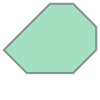

In [20]:
list_of_polygons[1]

(-0.5, 1293.5, 1176.5, -0.5)

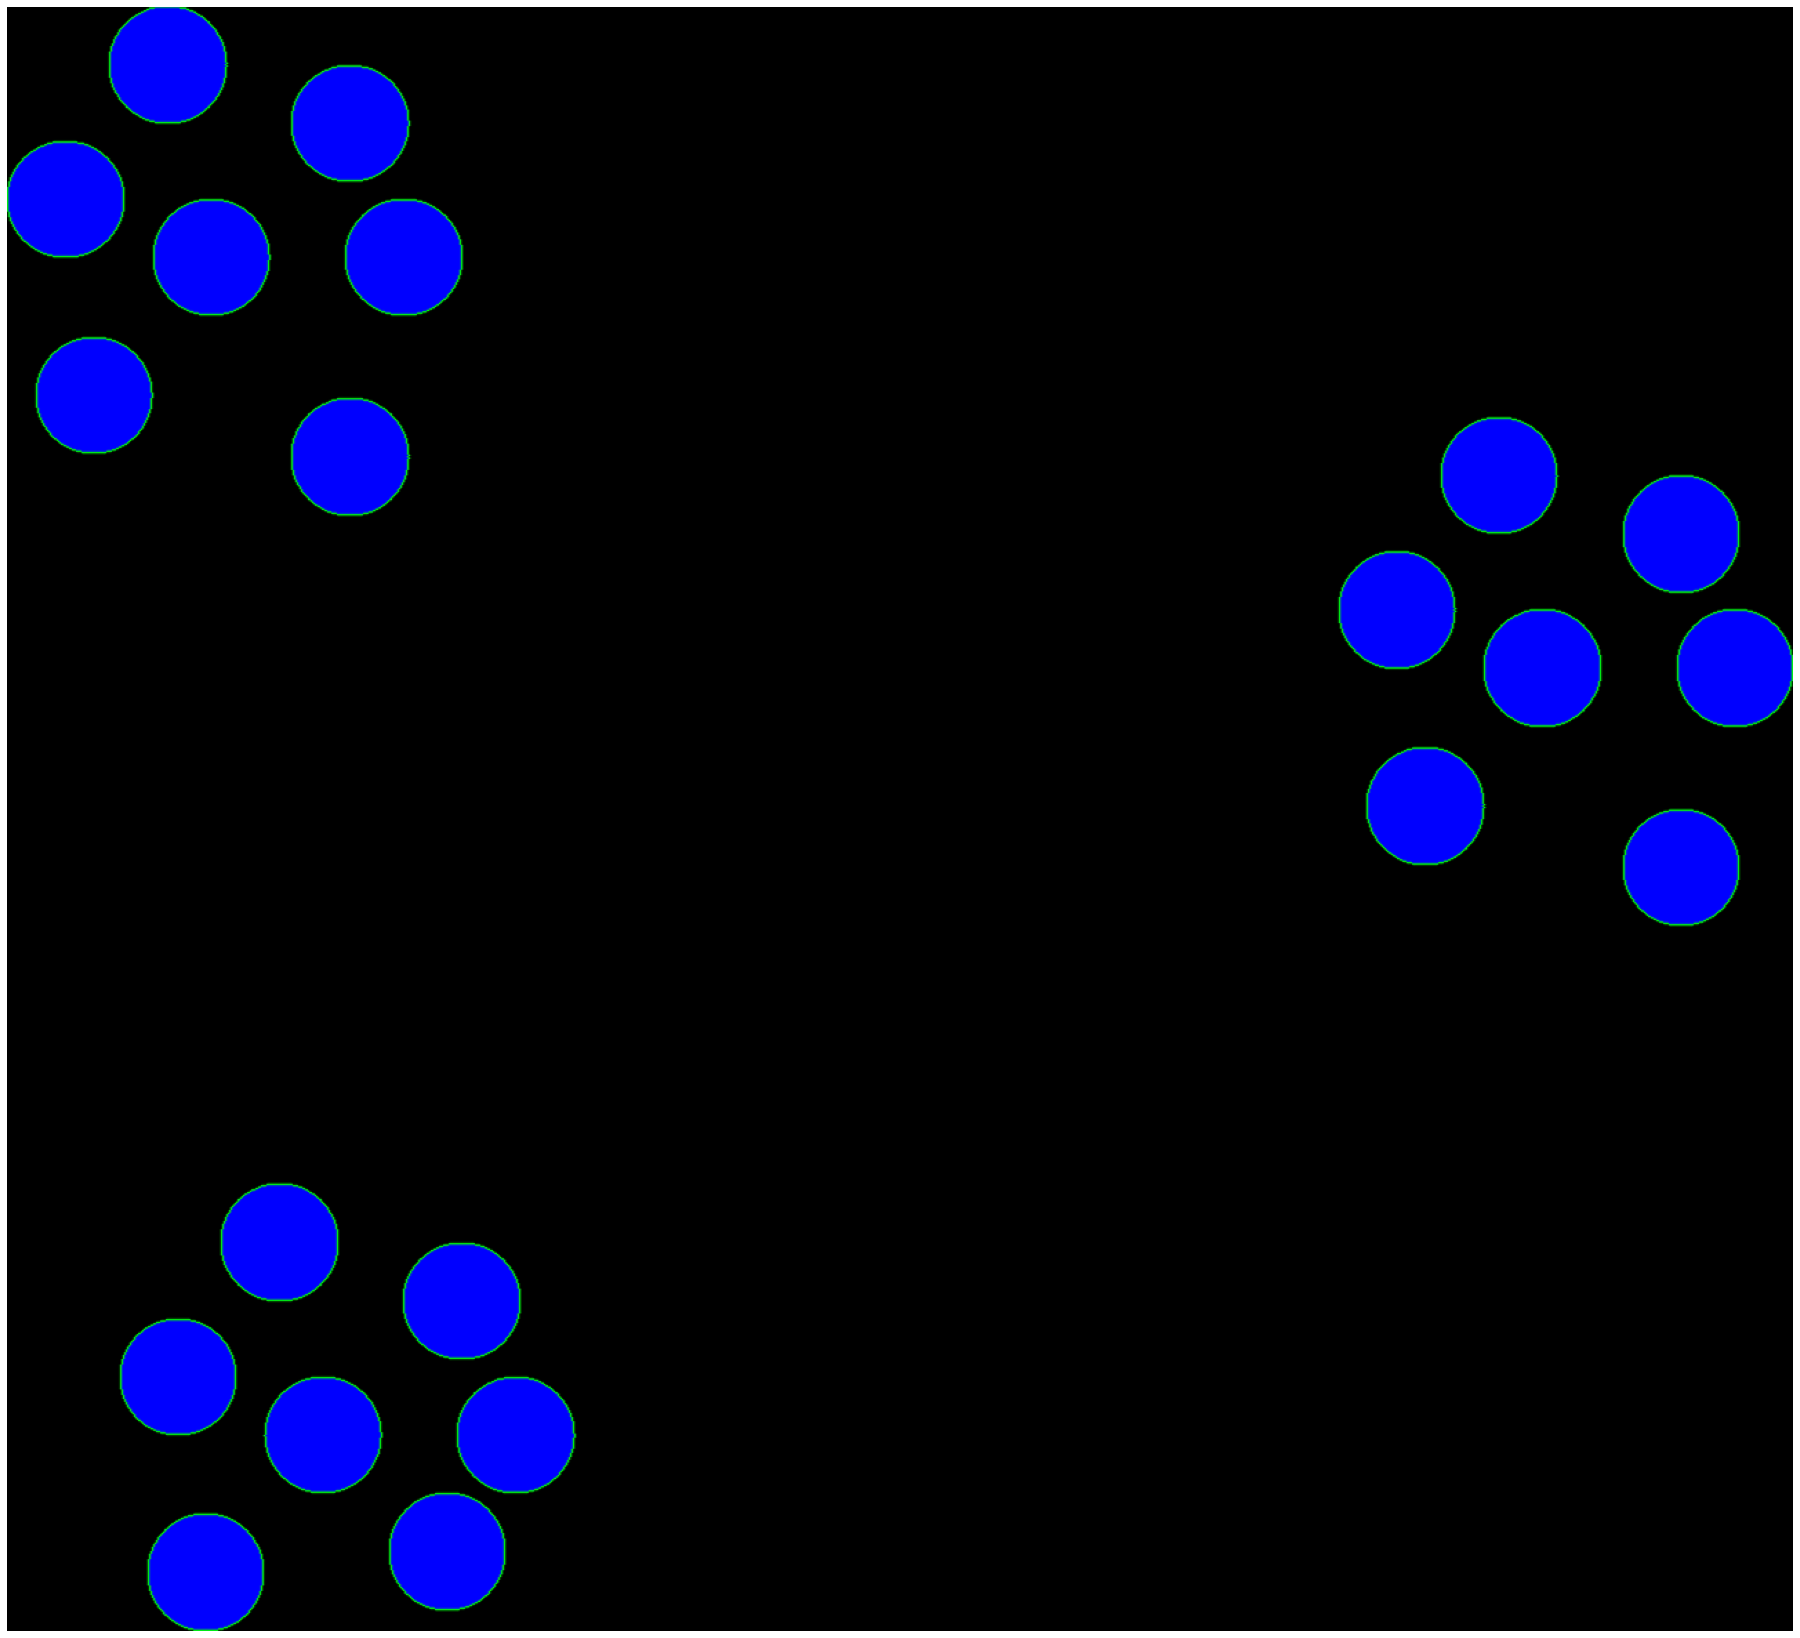

In [54]:
import cv2
img_path = r"F:\ETH Sicherung\ETH\Yujung Drive\images\Bilder\cluster.png"
img = cv2.imread(img_path)
imageCopy=np.copy(img)
grayImage=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale

contours, hierarchy = cv2.findContours(grayImage,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE) # detect contours
image_copy = img.copy()
mask = cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
plt.figure(figsize = (32, 32))
plt.imshow(mask)
plt.axis('off')

In [4]:
from PIL import Image

import cv2
img_path = r"C:\Users\mackerm\Desktop\ETH\Aconity MIDI\Marc ackermann\copped_images_bottomcrop\to_binarize\processedImages\33_01_cropped_processed.jpg"
img = polygon_detection(img_path)

img_path = r"F:\semi_weakly_dataset\ref\14_1000x.png"
# img = Image.open(img_path)
# width, height = img.size
# new_size=(int(width/2), int(height/2))
# new_img = img.resize(new_size)
#
# new_img.save("14_1000x2.png")

# Statistical Information per Image

In [42]:
import pandas as pd
import numpy as np
import cv2
import os
from rdfpy import rdf
import statistics

In [92]:
def calculate_rdf(df):
    if df.empty:
        x = 0
        y = 0
    else:
        x=df['centroid_x'].values
        y=df['centroid_y'].values
    coords = np.column_stack((x, y))
    g_r, radii = rdf(coords, dr=0.1)
    df2 = pd.DataFrame(data = radii, columns=["radius"])
    df2["g_r"]=g_r
    df2 = df2.dropna()
    df2 = df2[(df2 != 0).all(axis=1)]
    df2 = df2.reset_index(drop=True)
    rad = df2["radius"]
    if rad.empty:
        quartile_value = 600
    else:
        quartile_value = (statistics.median(rad)-min(rad))*0.5+min(rad)
    return quartile_value

In [94]:
# This should be changed depending on the magnification
micrometer_per_pixel = 2.146 # 0.48 pixel per µm (100x) => 2.0833 mu/px, MIDI 466px per 1mm =>2.146
LOM_stat = pd.DataFrame()
poly_result_path = r"F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\600\to_binarize\img\csv_neu"
for result in os.listdir(poly_result_path):
  result_path = os.path.join(poly_result_path, result)
  sample_name = result.split('/')[0]
  print(sample_name)
  final_df = pd.read_csv(result_path)
  new_stat = {'Image_Name': sample_name,
              'Area_avg': round(np.mean(final_df['Area']*micrometer_per_pixel**2), 3),
              'Area_max': round(np.max(final_df['Area']*micrometer_per_pixel**2), 3),
              'Area_std': round(np.std(final_df['Area']*micrometer_per_pixel**2), 3),
              'Aspect_ratio_avg': round(np.mean(final_df['Aspect Ratio']), 3),
              'Aspect_ratio_std': round(np.std(final_df['Aspect Ratio']), 3),
              'Roundness_avg': round(np.mean(final_df['Roundness']), 3),
              'Roundness_std': round(np.std(final_df['Roundness']), 3),
              'Max angle': round(np.max(final_df['Max angle']), 3),
              'Uniqueness_avg': round(np.mean(final_df['Uniqueness']), 3),
              'Uniqueness_std': round(np.std(final_df['Uniqueness']), 3),
              'Pore counts': round(np.mean(final_df['Pore counts']), 3),
              'RDF025': round(calculate_rdf(final_df), 3)
             }
  new_stat = pd.DataFrame([new_stat])
  LOM_stat = pd.concat([LOM_stat, new_stat], axis = 0)

new_path = r"F:\ETH Sicherung\ETH\Aconity MIDI\Marc ackermann\600\to_binarize\img\csv_neu\result.csv"
LOM_stat.to_csv(new_path, index = False)

processedImages_600x60081_4_4.csv
processedImages_600x6004_1_1.csv
processedImages_600x6004_1_2.csv
processedImages_600x6004_2_1.csv
processedImages_600x6004_2_2.csv
processedImages_600x6004_2_3.csv
processedImages_600x6004_3_1.csv
processedImages_600x6004_3_2.csv
processedImages_600x6004_3_3.csv
processedImages_600x6004_3_4.csv
processedImages_600x6004_4_1.csv
processedImages_600x6004_4_2.csv
processedImages_600x6004_4_3.csv
processedImages_600x6004_4_4.csv
processedImages_600x6005_1_1.csv
processedImages_600x6005_1_2.csv
processedImages_600x6005_1_3.csv
processedImages_600x6005_2_1.csv
processedImages_600x6005_2_2.csv
processedImages_600x6005_2_3.csv
processedImages_600x6005_2_4.csv
processedImages_600x6005_3_1.csv
processedImages_600x6005_3_2.csv
processedImages_600x6005_3_3.csv
processedImages_600x6005_3_4.csv
processedImages_600x6005_4_1.csv
processedImages_600x6005_4_2.csv
processedImages_600x6005_4_3.csv
processedImages_600x6005_4_4.csv
processedImages_600x6006_1_1.csv
processed

processedImages_600x60021_4_1.csv
processedImages_600x60021_4_2.csv
processedImages_600x60021_4_3.csv
processedImages_600x60022_1_1.csv
processedImages_600x60022_1_2.csv
processedImages_600x60022_1_3.csv
processedImages_600x60022_1_4.csv
processedImages_600x60022_2_1.csv
processedImages_600x60022_2_2.csv
processedImages_600x60022_2_3.csv
processedImages_600x60022_2_4.csv
processedImages_600x60022_3_1.csv
processedImages_600x60022_3_2.csv
processedImages_600x60022_3_3.csv
processedImages_600x60022_3_4.csv
processedImages_600x60022_4_1.csv
processedImages_600x60022_4_2.csv
processedImages_600x60022_4_3.csv
processedImages_600x60022_4_4.csv
processedImages_600x60023_1_1.csv
processedImages_600x60023_1_2.csv
processedImages_600x60023_1_3.csv
processedImages_600x60023_1_4.csv
processedImages_600x60023_2_1.csv
processedImages_600x60023_2_2.csv
processedImages_600x60023_2_3.csv
processedImages_600x60023_2_4.csv
processedImages_600x60023_3_1.csv
processedImages_600x60023_3_2.csv
processedImage

C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60036_3_2.csv
processedImages_600x60036_3_3.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60036_3_4.csv
processedImages_600x60036_4_1.csv
processedImages_600x60036_4_2.csv
processedImages_600x60036_4_3.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60036_4_4.csv
processedImages_600x60037_1_1.csv
processedImages_600x60037_1_2.csv
processedImages_600x60037_1_3.csv
processedImages_600x60037_1_4.csv
processedImages_600x60037_2_1.csv
processedImages_600x60037_2_2.csv
processedImages_600x60037_2_3.csv
processedImages_600x60037_2_4.csv
processedImages_600x60037_3_1.csv
processedImages_600x60037_3_2.csv
processedImages_600x60037_3_3.csv
processedImages_600x60037_3_4.csv
processedImages_600x60037_4_1.csv
processedImages_600x60037_4_2.csv
processedImages_600x60037_4_3.csv
processedImages_600x60037_4_4.csv
processedImages_600x60040_1_1.csv
processedImages_600x60040_1_2.csv
processedImages_600x60040_1_3.csv
processedImages_600x60040_1_4.csv
processedImages_600x60040_2_1.csv
processedImages_600x60040_2_2.csv
processedImages_600x60040_2_3.csv
processedImages_600x60040_3_1.csv
processedImages_600x60040_3_2.csv
processedImages_600x60040_3_3.csv
processedImages_600x60040_3_4.csv
processedImages_600x60040_4_1.csv
processedImage

C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60050_1_3.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60050_1_4.csv
processedImages_600x60050_2_1.csv
processedImages_600x60050_2_2.csv
processedImages_600x60050_2_3.csv
processedImages_600x60050_2_4.csv
processedImages_600x60050_3_1.csv
processedImages_600x60050_3_2.csv
processedImages_600x60050_3_3.csv
processedImages_600x60050_3_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60050_4_1.csv
processedImages_600x60050_4_2.csv
processedImages_600x60050_4_3.csv
processedImages_600x60050_4_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60051_1_1.csv
processedImages_600x60051_1_2.csv
processedImages_600x60051_1_3.csv
processedImages_600x60051_1_4.csv
processedImages_600x60051_2_1.csv
processedImages_600x60051_2_2.csv
processedImages_600x60051_2_3.csv
processedImages_600x60051_2_4.csv
processedImages_600x60051_3_1.csv
processedImages_600x60051_3_2.csv
processedImages_600x60051_3_3.csv
processedImages_600x60051_3_4.csv
processedImages_600x60051_4_1.csv
processedImages_600x60051_4_2.csv
processedImages_600x60051_4_3.csv
processedImages_600x60051_4_4.csv
processedImages_600x60052_1_1.csv
processedImages_600x60052_1_2.csv
processedImages_600x60052_1_3.csv
processedImages_600x60052_1_4.csv
processedImages_600x60052_2_1.csv
processedImages_600x60052_2_2.csv
processedImages_600x60052_2_3.csv
processedImages_600x60052_2_4.csv
processedImages_600x60052_3_1.csv
processedImages_600x60052_3_2.csv
processedImages_600x60052_3_3.csv
processedImages_600x60052_3_4.csv
processedImages_600x60052_4_1.csv
processedImage

C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60059_2_2.csv
processedImages_600x60059_2_3.csv
processedImages_600x60059_2_4.csv
processedImages_600x60059_3_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60059_3_2.csv
processedImages_600x60059_3_3.csv
processedImages_600x60059_3_4.csv
processedImages_600x60059_4_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60059_4_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60059_4_3.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60059_4_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60060_1_1.csv
processedImages_600x60060_1_2.csv
processedImages_600x60060_1_3.csv
processedImages_600x60060_1_4.csv
processedImages_600x60060_2_1.csv
processedImages_600x60060_2_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60060_2_3.csv
processedImages_600x60060_2_4.csv
processedImages_600x60060_3_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60060_3_2.csv
processedImages_600x60060_3_3.csv
processedImages_600x60060_3_4.csv
processedImages_600x60060_4_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60060_4_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60060_4_3.csv
processedImages_600x60060_4_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_1_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_1_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_1_3.csv
processedImages_600x60061_1_4.csv
processedImages_600x60061_2_1.csv
processedImages_600x60061_2_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_2_3.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_2_4.csv
processedImages_600x60061_3_1.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_3_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_3_3.csv
processedImages_600x60061_3_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_4_1.csv
processedImages_600x60061_4_2.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in long_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60061_4_3.csv
processedImages_600x60061_4_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60062_1_1.csv
processedImages_600x60062_1_2.csv
processedImages_600x60062_1_3.csv
processedImages_600x60062_1_4.csv
processedImages_600x60062_2_1.csv
processedImages_600x60062_2_2.csv
processedImages_600x60062_2_3.csv
processedImages_600x60062_2_4.csv
processedImages_600x60062_3_1.csv
processedImages_600x60062_3_2.csv
processedImages_600x60062_3_3.csv
processedImages_600x60062_3_4.csv
processedImages_600x60062_4_1.csv
processedImages_600x60062_4_2.csv
processedImages_600x60062_4_3.csv
processedImages_600x60062_4_4.csv
processedImages_600x60063_1_1.csv
processedImages_600x60063_1_2.csv
processedImages_600x60063_1_3.csv
processedImages_600x60063_1_4.csv
processedImages_600x60063_2_1.csv
processedImages_600x60063_2_2.csv
processedImages_600x60063_2_3.csv
processedImages_600x60063_2_4.csv
processedImages_600x60063_3_1.csv
processedImages_600x60063_3_2.csv
processedImages_600x60063_3_3.csv
processedImages_600x60063_3_4.csv
processedImages_600x60063_4_1.csv
processedImage

C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60074_3_1.csv
processedImages_600x60074_3_2.csv
processedImages_600x60074_3_3.csv
processedImages_600x60074_3_4.csv
processedImages_600x60074_4_1.csv
processedImages_600x60074_4_2.csv
processedImages_600x60074_4_3.csv
processedImages_600x60074_4_4.csv
processedImages_600x60075_1_1.csv
processedImages_600x60075_1_2.csv
processedImages_600x60075_1_3.csv
processedImages_600x60075_1_4.csv
processedImages_600x60075_2_1.csv
processedImages_600x60075_2_2.csv
processedImages_600x60075_2_3.csv
processedImages_600x60075_2_4.csv
processedImages_600x60075_3_1.csv
processedImages_600x60075_3_2.csv
processedImages_600x60075_3_3.csv
processedImages_600x60075_3_4.csv
processedImages_600x60075_4_1.csv
processedImages_600x60075_4_2.csv
processedImages_600x60075_4_3.csv
processedImages_600x60075_4_4.csv


C:\Users\acker\miniconda3\envs\tensorflow\lib\site-packages\rdfpy\rdfpy.py:98: RuntimeWarning: divide by zero encountered in double_scalars
  rho = N / np.prod(dims) # number density


processedImages_600x60076_1_1.csv
processedImages_600x60076_1_2.csv
processedImages_600x60076_1_3.csv
processedImages_600x60076_1_4.csv
processedImages_600x60076_2_1.csv
processedImages_600x60076_2_2.csv
processedImages_600x60076_2_3.csv
processedImages_600x60076_2_4.csv
processedImages_600x60076_3_1.csv
processedImages_600x60076_3_2.csv
processedImages_600x60076_3_3.csv
processedImages_600x60076_3_4.csv
processedImages_600x60076_4_1.csv
processedImages_600x60076_4_2.csv
processedImages_600x60076_4_3.csv
processedImages_600x60076_4_4.csv
processedImages_600x60077_1_1.csv
processedImages_600x60077_1_2.csv
processedImages_600x60077_1_3.csv
processedImages_600x60077_1_4.csv
processedImages_600x60077_2_1.csv
processedImages_600x60077_2_2.csv
processedImages_600x60077_2_3.csv
processedImages_600x60077_2_4.csv
processedImages_600x60077_3_1.csv
processedImages_600x60077_3_2.csv
processedImages_600x60077_3_3.csv
processedImages_600x60077_3_4.csv
processedImages_600x60077_4_1.csv
processedImage